In [1]:
from helpers import *

import sys

import bz2
import json

import numpy as np
import scipy

import pandas as pd
# ttest and euclidean distance
from scipy.stats import ttest_ind, bootstrap
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import chart_studio

import chart_studio.plotly as py

import chart_studio.tools as tls


import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nicolasbaldwin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nicolasbaldwin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### THIS NOTEBOOK IS USED TO PLOT THE PLOTS ON THE WEBSITE OF THE ’EXPLORATION OF RESULTS’ AND ’TOPIC ANALYSIS’ SECTION. FOR DETAILED EXPLANATION AND STORYLINE SEE WEBSITE

In [4]:
def send_figure_to_internet(fig,filename):
    """function to save plotly express images and put them on website"""
    username = 'ogim'
    api_key = 'z9ZRECEZuhRpmGQjGcMX' # your api key - go to profile > settings > regenerate key
    chart_studio.tools.set_credentials_file(username=username, api_key=api_key)


    url = py.plot(fig, filename = filename, auto_open=True)
    print(url)
    print('link:')
    print(tls.get_embed(url)) #change to your url
    


In [5]:
#File with all the quotes and predictions of our dataset
file = PREPROCESSED_FOLDER + 'quotes_labeled_cleaned_predicted2.json.bz2'

### ANALYSIS OF MODEL

In [6]:
def get_score_by_speaker(path,min_length_quote = 0,min_tot_quotes = 0, keep_RD = False , keep_exclusives = True):
    """Function to fetch the mean political score (prob dem) of every speaker in a dataframe based on his quotes"""
    # arguments:
        # path: path of file containing data
        # min_tot_quotes: if a speaker has less than min_tot_quotes in dataset, drop him
        # min_length_quote: if a quote is shorter than min_length quote, drop it
        # keep_RD: if True keeps speakers that are labeled as RD (meaning they belon)
        # keep exclusives: if True keeps speakers that are labeled 'R'(republican) or 'D'(democrat)
    DF_PATH = path
    
    def avg_by_chunk(min_length_quote, keep_RD  , keep_exclusives ):
        """returns the mean political score (prob dem) of every speaker by chunk (done due to memory issues)"""
        result = []
        i = 0
        #for each chunk of the file
        with pd.read_json(DF_PATH,lines = True, compression= 'bz2',chunksize= 1000000) as df_reader:
            for df in df_reader:
                if not keep_RD:
                    df = df[df.party_label != 'RD']
                if not keep_exclusives:
                    df = df[df.party_label == 'RD']
                #drop quotes that have less than min_length_quote words
                if min_length_quote > 0:
                    df = df[df.quotation_clean.apply(lambda x: len(x.split())) >= min_length_quote]
                #compute the mean prob_dem of a speaker and the number of quotes we've seen (useful for later to group together the chunks)
                by_speaker = df.groupby('id')['prob_dem'].agg(['mean','size']).reset_index()
                #add extra info specific to  speaker to dataframe
                by_speaker = by_speaker.merge(df[['speaker','party_label','id']],on = 'id').drop_duplicates('id')
                #append result
                result.append(by_speaker)
                print(i, end='  ')
                i+=1
        #return all chunks concatenated in on dataframe
        return pd.concat(result)
    
    def aggregate_averages(df):
        """function called after 'avg_by_chunk()' to calculate the true political of a speaker (group together the chunks)"""
        avg = 0
        tot_obs = 0
        #iterate quotes of a speaker
        for nb,row in df.iterrows():
            #remember total number of quotes
            tot_obs += row['size']
            #add to weighted average
            avg += row['size'] * row['mean']
        #compute total average
        avg = avg/tot_obs
        return avg,tot_obs
    
    #compute average prob_dem of speakers by chunks
    res = avg_by_chunk(min_length_quote,keep_RD,keep_exclusives)
    #aggregate together averages of a speaker to compute real avg_prob_dem
    scores_by_speaker = res[['mean','size','id']].groupby('id').apply(aggregate_averages).reset_index().rename(columns = {0: 'avg_prob_dem'})

    #unpack values in to seperate columns
    scores_by_speaker['tot_quotes'] = scores_by_speaker.avg_prob_dem.apply(lambda x: x[1])
    scores_by_speaker['avg_prob_dem'] = scores_by_speaker.avg_prob_dem.apply(lambda x: x[0])
    
    #merge to add relevant information of speaker
    scores_by_speaker = scores_by_speaker.merge(res[['id','speaker','party_label']], on = 'id').drop_duplicates('id')
    
    if min_tot_quotes > 0:
        #drop speakers that have less than min_tot_quotes in dataset
        scores_by_speaker = scores_by_speaker[scores_by_speaker.tot_quotes >= min_tot_quotes]
    return scores_by_speaker


def get_quotes_by_speaker_id(ids,path,min_length_quote = 0,keep_RD = False , keep_exclusives = True):
    """given a set of speaker ids, extract all quotes of these speakers from dataset"""
    # arguments:
        # ids: ids of speaker we want to extract quotes from
        # path: path of file containing data
        # min_tot_quotes: if a speaker has less than min_tot_quotes in dataset, drop him
        # min_length_quote: if a quote is shorter than min_length quote, drop it
        # keep_RD: if True keeps speakers that are labeled as RD (meaning they belon)
        # keep exclusives: if True keeps speakers that are labeled 'R'(republican) or 'D'(democrat)
    DF_PATH = path
    result = []
    i = 0
    #iterate dataset in chunks
    with pd.read_json(DF_PATH,lines = True, compression= 'bz2',chunksize= 1000000) as df_reader:
        for df in df_reader:
            #if keep RD is true keep speaker labeled 'RD'
            if not keep_RD:
                df = df[df.party_label != 'RD']
        
            #if keep_exclusives is true keep speakers labeled 'D' or 'R'
            if not keep_exclusives:
                df = df[df.party_label == 'RD']
                
            #drop quotes that have less than min_length_quote words
            if min_length_quote >0:
                df = df[df.quotation_clean.apply(lambda x: len(x.split())) >= min_length_quote]
            
            #keep only quotes of speakers we wand
            df = df[df.id.isin(ids)]
            
            #append only if there is at least on quote left after our filtering
            if df.shape[0] > 0:
                result.append(df)
                
            print(i, end='  ')
            i+=1
            
    return pd.concat(result)

def get_accuracy_by_quote_length(path):
    """Function That Groups quotes of our dataset by the length of the quote and calculates their accuracy"""
    DF_PATH = path
    
    def avg_by_chunk():
        """returns the accuracy for every quote_length by chunk"""
        def compute_chunk_accuracy(df):
            #round out our prediction
            df['pred'] = df['prob_dem'].apply(lambda x: 'R' if x < 0.5 else 'D')
            #compute accuracy
            accuracy = df[df.party_label == df.pred].shape[0]/df.shape[0]
            #count number of quotes
            size = df.shape[0]
            #return accuracy and how many quotes were in this statistic
            return accuracy,size
            
        
        result = []
        i = 0
        #for each chunk of the file
        with pd.read_json(DF_PATH,lines = True, compression= 'bz2',chunksize= 1000000) as df_reader:
            for df in df_reader:
                #remove quotes that are labeled 'RD' (speakers that are both democrats and republicans on dataset)
                df = df[df.party_label != 'RD']

                #count number of words in quote
                df['quote_length'] = df.quotation_clean.apply(lambda x: len(x.split()))
                
                #compute the mean prob_dem (political score) of a quote_length and the number of quotes we've seen (useful for later to group together the chunks)
                df = df.groupby('quote_length').apply(compute_chunk_accuracy).reset_index().rename(columns = {0: 'accuracy/size'})
                
                #unpack results
                df['accuracy'] = df['accuracy/size'].apply(lambda x: x[0])
                df['size'] = df['accuracy/size'].apply(lambda x: x[1])
                df = df.drop(columns = ['accuracy/size'])
                #append result
                result.append(df)
                print(i, end='  ')
                i+=1
                
        #return all chunks concatenated in on dataframe
        return pd.concat(result)
    
    def aggregate_averages(df):
        """function called after 'avg_by_chunk()' to calculate the true accuracy of a quote_length (group together the chunks)"""
        avg = 0
        tot_obs = 0
        #iterate quotes of a speaker
        for nb,row in df.iterrows():
            #remember total number of quotes
            tot_obs += row['size']
            #add to weighted average
            avg += row['size'] * row['accuracy']
        #compute total average
        avg = avg/tot_obs
        return avg,tot_obs
    
    #compute accuracy by quote_length by chunks
    res = avg_by_chunk()
    
    #aggregate together averages of a speaker to compute real accuracy
    scores_by_length = res.groupby('quote_length').apply(aggregate_averages).reset_index().rename(columns = {0: 'accuracy'})

    scores_by_length['tot_quotes'] = scores_by_length.accuracy.apply(lambda x: x[1])
    scores_by_length['accuracy'] = scores_by_length.accuracy.apply(lambda x: x[0])
    
  
    return scores_by_length
    

In [7]:
#get dataframe of political score of every speaker
by_speaker = get_score_by_speaker(file,keep_RD = False , keep_exclusives = True)


0  1  2  3  4  5  6  7  

In [71]:
def plot_score_by_speaker(df,title):
    """function to plot speaker's political score on graph"""
    #ensures that republicans are in red and democrats in blue
    color_code = ["red", "blue"] if df.party_label.values[0] == 'R' else [ "blue","red"]
    #scatter plot
    fig = px.scatter(df, x =  'avg_prob_dem', y = 'party_label', color = 'party_label' , marginal_x="histogram",color_discrete_sequence=color_code, hover_data= ['party_label','speaker','avg_prob_dem'], title = title,labels=dict(avg_prob_dem="political score"))
    #add vertical line to indicate seperation between democrats and republicans
    fig.add_vline(x=0.5,line_width=3, line_dash="dash",annotation_text=" political score = 0.5")
    fig.show()
    return fig

#### Let's compute the accuracy of our model

In [14]:
def print_stats_of_pred(by_speaker,get_stats_back = False):
    """print metrics of our model predictions """
    #speakers classified as republicans and whose label is republican (correctly classified)
    true_republicans = by_speaker[np.logical_and(by_speaker.party_label == 'R', by_speaker.avg_prob_dem < 0.5)]
    #speakers classified as democrats and whose label is democrat (correctly classified)
    true_democrats = by_speaker[np.logical_and(by_speaker.party_label == 'D', by_speaker.avg_prob_dem >= 0.5)]
    #speakers classified as republicans and whose label is democrat (falsely classified)
    false_republicans = by_speaker[np.logical_and(by_speaker.party_label == 'D', by_speaker.avg_prob_dem < 0.5)]
    #speakers classified as democrats and whose label is republican (falsely classified)
    false_democrats = by_speaker[np.logical_and(by_speaker.party_label == 'R', by_speaker.avg_prob_dem >= 0.5)]

    accuracy = (true_democrats.shape[0]+ true_republicans.shape[0])/(true_democrats.shape[0]+ true_republicans.shape[0]+ false_democrats.shape[0] + false_republicans.shape[0])
    precision = true_democrats.shape[0]/(true_democrats.shape[0] + false_democrats.shape[0])
    recall = true_democrats.shape[0]/(true_democrats.shape[0] + false_republicans.shape[0])
    f1_score = 2*precision*recall/(precision + recall)

    true_negative_rate = true_republicans.shape[0]/(true_republicans.shape[0] + false_democrats.shape[0])
  

    print('accuracy: ', accuracy)
    print('precision: ', precision)
    print('recall: ', recall)
    print('f1_score: ', f1_score)
    print('true_negative_rate: ', true_negative_rate)
    if get_stats_back:
        return true_republicans,true_democrats,false_republicans,false_democrats
    
true_republicans,true_democrats,false_republicans,false_democrats = print_stats_of_pred(by_speaker,get_stats_back = True)

accuracy:  0.9352787394898608
precision:  0.911504424778761
recall:  0.967403314917127
f1_score:  0.9386223532564996
true_negative_rate:  0.901634601475481


#### As we can see some of the speakers are misclassified, let's take a closer look at these speakers and their quotes

In [15]:
#extract ids of misclassified speakers
falsely_classified_speakers = false_republicans.id.values.tolist()
falsely_classified_speakers.extend(false_democrats.id.values.tolist())

#get the quotes of the misclassified speakers
quotes_falsely_classified = get_quotes_by_speaker_id(falsely_classified_speakers,file)
quotes_falsely_classified = quotes_falsely_classified.merge(pd.concat((false_republicans,false_democrats))[['id','tot_quotes']], on = 'id')


0  1  2  3  4  5  6  7  

/Users/nicolasbaldwin/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

No handles with labels found to put in legend.


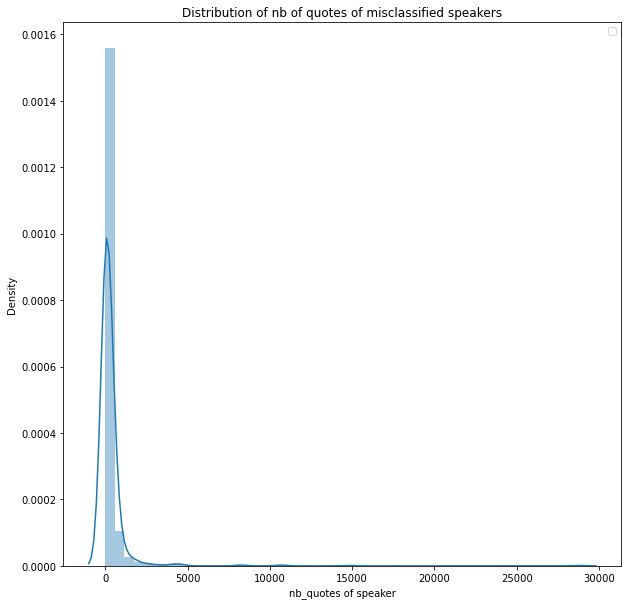

In [18]:
#Distribution of nb of quotes of misclassified speakers
nb_quotes_per_speaker = quotes_falsely_classified.groupby('id').size().reset_index().rename(columns = {0:'nb_quotes'})

sns.distplot(nb_quotes_per_speaker.nb_quotes)
plt.rcParams["figure.figsize"] = (20,20)
plt.title('Distribution of nb of quotes of misclassified speakers')
plt.xlabel('nb_quotes of speaker')
plt.legend()
plt.show()



In [19]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [20]:
# compute Distribution of nb of quotes of misclassified speakers
nb_quotes_per_speaker = quotes_falsely_classified.groupby('id').size().reset_index().groupby(0).count().reset_index().rename(columns = {0:'nb_quotes','id':'frequency'})
nb_quotes_per_speaker

,nb_quotes,frequency
0,1,119
1,2,57
2,3,30
3,4,16
4,5,14
...,...,...
391,8358,1
392,10542,1
393,10882,1
394,14827,1


In [21]:
density_of_1_quote_per_speaker =  nb_quotes_per_speaker[nb_quotes_per_speaker.nb_quotes == 1].frequency.values[0]/np.sum(nb_quotes_per_speaker.frequency.values)
print('density of 1 quote per speaker among misclassified', density_of_1_quote_per_speaker)

density of 1 quote per speaker among misclassified 0.1299126637554585


#### As we can see approximately 13% of our missclassifed speakers have only one quote, so let's investigate these !

In [27]:
#PLOT quotes of miscalssified speakers with only 1 quote

nb_quotes_per_id = quotes_falsely_classified.groupby('id').size()
ids_of_speakers_with_one_quote = nb_quotes_per_id[nb_quotes_per_id.values == 1].index.values
quotes = quotes_falsely_classified[quotes_falsely_classified.id.isin(ids_of_speakers_with_one_quote)]

color_code = ["red", "blue"] if quotes.party_label.values[0] == 'R' else [ "blue","red"]
fig = px.scatter(quotes, x =  'prob_dem', y = 'party_label', color = 'party_label' ,color_discrete_sequence=color_code, hover_data= ['party_label','speaker','prob_dem','quotation'], title = 'Misclassified politicians that have only one quote',labels=dict(prob_dem="political score"))
fig.add_vline(x=0.5,line_width=3, line_dash="dash",annotation_text=" political score = 0.5")
fig.show()

In [28]:
send_figure_to_internet(fig,'Misclassified politicians that have only one quote')

https://plotly.com/~ogim/25/
link:
<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~ogim/25.embed" height="525" width="100%"></iframe>


#### For the other quotes, let's use bootstrapping to provide confidence intervals

In [26]:
#extract id of missclassified speakers with more than one quote
ids_of_speakers_with_more_than_one_quote = nb_quotes_per_id[nb_quotes_per_id.values > 1].index.values
#extract quotes of missclassified speakers with more than one quote
quotes_speakers_more_than_one_quote_df = quotes_falsely_classified[quotes_falsely_classified.id.isin(ids_of_speakers_with_more_than_one_quote)]
#calculate political score ot these speakers
more_than_one_quote_speakers_scores = quotes_speakers_more_than_one_quote_df.groupby('id')['prob_dem'].mean().reset_index().rename(columns = {'prob_dem' : 'avg_prob_dem'})
#add relevant information about speaker to dataframe
more_than_one_quote_speakers_scores =  more_than_one_quote_speakers_scores.merge(quotes_speakers_more_than_one_quote_df[['id','speaker','party_label']], on = 'id').drop_duplicates('id')

def bootstrap_method(x):
    """function to calculate the confidence intervals of a speaker"""
    vals = x.prob_dem.values
    #if all political scores of a speaker are equal, change one slightly to avoid a division by 0
    if np.all(vals == vals[0]):
        vals[0] = vals[0] + 0.001
    #scipy bootstrap method
    return bootstrap((vals,), np.mean, confidence_level=0.95,vectorized=True)

#calculate 95% CI of misclassified speakers
ci_per_id =  quotes_speakers_more_than_one_quote_df.groupby('id').apply(bootstrap_method).reset_index().rename(columns = {0 : 'CI'})
more_than_one_quote_speakers_scores = more_than_one_quote_speakers_scores.merge(ci_per_id, on = 'id')

#unpack results
more_than_one_quote_speakers_scores['lower_CI'] = more_than_one_quote_speakers_scores.avg_prob_dem.values - more_than_one_quote_speakers_scores.CI.apply(lambda x: x.confidence_interval.low).values
more_than_one_quote_speakers_scores['upper_CI'] =  more_than_one_quote_speakers_scores.CI.apply(lambda x: x.confidence_interval.high).values - more_than_one_quote_speakers_scores.avg_prob_dem.values
more_than_one_quote_speakers_scores['ste_CI'] = more_than_one_quote_speakers_scores.CI.apply(lambda x: x.standard_error)


In [64]:
#ensures republicans are in red and democrats are in blue
color_code = ["red", "blue"] if more_than_one_quote_speakers_scores.party_label.values[0] == 'R' else [ "blue","red"]
#plot political score of misclassified speakers with 95% CI
fig = px.scatter(more_than_one_quote_speakers_scores.sample(100), x =  'avg_prob_dem', y =np.array([x for x in range(100)]),error_x='ste_CI',
                color = 'party_label',color_discrete_sequence=color_code, labels = {'y' : 'speaker','avg_prob_dem':"political score"},
                hover_data= ['party_label','speaker','avg_prob_dem'], width= 500, height=1000, title = 'Sample of Misclassified Speakers with CI')
fig.add_vline(x=0.5,line_width=3, line_dash="dash",annotation_text=" political score= 0.5")


In [65]:
send_figure_to_internet(fig,'Sample of Misclassified Speakers with CI')

https://plotly.com/~ogim/29/
link:
<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~ogim/29.embed" height="525" width="100%"></iframe>


In [38]:
#Calculate proportion of misclassified speakers that are both classified as republicans and democrats due to CI
ci_in_dems = (more_than_one_quote_speakers_scores.avg_prob_dem - more_than_one_quote_speakers_scores.ste_CI) <= 0.5
ci_in_reps = (more_than_one_quote_speakers_scores.avg_prob_dem + more_than_one_quote_speakers_scores.ste_CI) >= 0.5
speakers_uncertain_classification = more_than_one_quote_speakers_scores[np.logical_and(ci_in_dems ,ci_in_reps)]
speakers_uncertain_classification.shape[0]/more_than_one_quote_speakers_scores.shape[0]

0.3312421580928482

### As we can see from this analysis, the majority of our misclassified speakers (approximately 0.33*(1-0.13) + 0.13 = 0.42%) due to not enough quotes for a speaker. This leads us to ask ouselves the following question: how many quotes do we need to correctly classify a speaker?

In [49]:
def compute_accuracy(df):
    """computes the accuracy of a group of predictions"""
     #speakers classified as republicans and whose label is republican (correctly classified)
    true_republicans = df[np.logical_and(df.party_label == 'R', df.avg_prob_dem < 0.5)]
    #speakers classified as democrats and whose label is democrat (correctly classified)
    true_democrats = df[np.logical_and(df.party_label == 'D', df.avg_prob_dem >= 0.5)]
    #speakers classified as republicans and whose label is democrat (falsely classified)
    false_republicans = df[np.logical_and(df.party_label == 'D', df.avg_prob_dem < 0.5)]
    #speakers classified as democrats and whose label is republican (falsely classified)
    false_democrats = df[np.logical_and(df.party_label == 'R', df.avg_prob_dem >= 0.5)]

    accuracy = (true_democrats.shape[0]+ true_republicans.shape[0])/(true_democrats.shape[0]+ true_republicans.shape[0]+ false_democrats.shape[0] + false_republicans.shape[0])
    return accuracy
    
#calcluate the accuracy in function of the number of quotes
accuracy_per_nb_quotes = by_speaker.groupby('tot_quotes').apply(compute_accuracy).reset_index().rename(columns = {0 : 'accuracy','tot_quotes': 'nb_quotes_of_speakers'})
accuracy_per_nb_quotes = accuracy_per_nb_quotes.merge(by_speaker.groupby('tot_quotes')['speaker'].size().reset_index().rename(columns = {'speaker' : 'size','tot_quotes': 'nb_quotes_of_speakers'}), on = ['nb_quotes_of_speakers'])

#plot result
fig = px.scatter(accuracy_per_nb_quotes[accuracy_per_nb_quotes['size'] > 50], x = 'nb_quotes_of_speakers',y = 'accuracy', trendline='ols', title = 'Accuracy Of Prediction in Funtion of the Number of Quotes of Speaker')
fig.add_hline(y=0.925,line_width=3, line_dash="dash",annotation_text=" accuracy = 0.925")


In [51]:
send_figure_to_internet(fig,'Accuracy Of Prediction in Funtion of the Number of Quotes of Speaker')

https://plotly.com/~ogim/34/
link:
<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~ogim/34.embed" height="525" width="100%"></iframe>


#### Consequently, our model needs at least 4 quotes per speaker to be able to classify a speaker with more certainty. Let's revisit our initial plot with only speakers that have at least 4 quotes 

### Now let's see if the length of a quote impacts the accuracy

In [44]:
score_by_length = get_accuracy_by_quote_length(file)

0  1  2  3  4  5  6  7  

In [45]:
def cumulative_proportion(df):
    """calculates the quantile"""
    quantiles = []
    first_time_in = True
    for nb,row in df.iterrows():
        row.tot_quotes
        if first_time_in:
            first_time_in = False
            cumulative_quant = row['proportion']
        else:
            cumulative_quant = (quantiles[-1] + row['proportion'])
        quantiles.append(cumulative_quant)
    return quantiles

#calculate the total number of quotes we have
tot_quote = np.sum(score_by_length.tot_quotes.values)
#compute the density of quotes that are a given length
score_by_length['proportion'] = score_by_length.tot_quotes.values/tot_quote
#compute the quantiles
score_by_length['quantile'] = cumulative_proportion(score_by_length)



In [46]:
#plot of Accuracy in function of length of quote
fig = px.scatter(score_by_length[score_by_length.tot_quotes >= 10],x = 'quote_length',y = 'accuracy',hover_data=['quote_length','accuracy','quantile'],title = 'Accuracy of Quotes in Function of the Length of the Quote',trendline='ols')
fig.add_hline(y=0.8,line_width=3, line_dash="dash",annotation_text=" accuracy = 0.8")



In [47]:
send_figure_to_internet(fig,'Accuracy of Quotes in Function of the Length of the Quote')

https://plotly.com/~ogim/36/
link:
<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~ogim/36.embed" height="525" width="100%"></iframe>


### As we can see the length of quote does impact the accruacy. We should keep only quotes with at least 4 words (after cleaning)

### NOW THAT WE HAVE UNDERSTOOD THE RESTICTIONS OF OUR MODEL, WE CAN PLOT THE POLITICAL OF THE SPEAKERS

In [48]:
#GET THE PREDICTIONS ADDING OUR 2 RESTRICTIONS (minimum length of a quote must be 4 and a speaker must have at least 4 quotes)
by_speaker_clean = get_score_by_speaker(file,min_length_quote = 4,min_tot_quotes = 4, keep_RD = False , keep_exclusives = True)


0  1  2  3  4  5  6  7  

In [72]:
fig = plot_score_by_speaker(by_speaker_clean, title = 'Predicted Political Score of All Speakers')
print_stats_of_pred(by_speaker_clean)


accuracy:  0.943962051776813
precision:  0.9179259259259259
recall:  0.9774412367881369
f1_score:  0.9467491786996715
true_negative_rate:  0.9091654369568781


#### The results are much more satisfying (accuracy of predicting the party of politician is 94.4%)

#### PLOTING FAMOUS POLITICIANS


In [62]:
p_and_vp = ['Joe Biden', 'Kamala Harris', 'Donald Trump', 'Mike Pence', 'Barack Obama' , 'Bernie Sanders',
                 'George W. Bush', 'Dick Cheney', 'Bill Clinton','George H. W. Bush', 'Dan Quayle','Hillary Clinton']
#extract famous politicians
p_and_vp_df = pd.DataFrame({'speaker': p_and_vp})
p_and_vp_df = p_and_vp_df.merge(by_speaker_clean, on = 'speaker')
p_and_vp_df

,speaker,id,avg_prob_dem,tot_quotes,party_label
0,Joe Biden,Q6279,0.877067,49593,D
1,Kamala Harris,Q10853588,0.897521,19093,D
2,Donald Trump,Q22686,0.094323,610850,R
3,Mike Pence,Q24313,0.111021,42496,R
4,Barack Obama,Q76,0.883263,138846,D
5,Bernie Sanders,Q359442,0.901877,75678,D
6,George W. Bush,Q207,0.387745,11074,R
7,Dick Cheney,Q48259,0.150645,2328,R
8,Bill Clinton,Q1124,0.834529,15072,D
9,George H. W. Bush,Q23505,0.184394,4278,R


In [73]:
#plot political score of famous politicians
color_code = ["red", "blue"] if p_and_vp_df.party_label.values[0] == 'R' else [ "blue","red"]
fig = px.scatter(p_and_vp_df, x =  'avg_prob_dem', y = 'party_label', color = 'party_label' ,color_discrete_sequence=color_code, hover_data= ['party_label','speaker','avg_prob_dem'], title = 'Political Score of Famous Politicians',labels=dict(avg_prob_dem="political score"))
fig.add_vline(x=0.5,line_width=3, line_dash="dash",annotation_text=" political score = 0.5")
fig.show()


In [74]:
send_figure_to_internet(fig,'Political Score of Famous Politicians')

https://plotly.com/~ogim/42/
link:
<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~ogim/42.embed" height="525" width="100%"></iframe>


# ANSWERING: Can we identify the various opinions of the parties on a given topic?

In [75]:
def get_quotes_off_keyword(path,keywords,min_length_quote = 0, keep_RD = False , keep_exclusives = True):
    """"extract all quotes that contain the specified keywords"""
    # arguments:
        # path: path of dataset
        # keywords: set of keywords that must be included in dataset
        # min_length_quote: if a quote is shorter than min_length quote, drop it
        # keep_RD: if True keeps speakers that are labeled as RD (meaning they belong)
        # keep exclusives: if True keeps speakers that are labeled 'R'(republican) or 'D' (democrat)
    result = []
    i = 0
    #iterate dataset in chunks
    with pd.read_json(path,lines = True, compression= 'bz2',chunksize= 1000000) as df_reader:
        for df in df_reader:
            if not keep_RD:
                    df = df[df.party_label != 'RD']
            if not keep_exclusives:
                df = df[df.party_label == 'RD']

            #keep only quotes that have all the keywords in the dataset
            for keyword in keywords:
                if df.shape[0] > 0:
                    df = df[df.quotation.apply(lambda x: x.lower()).str.contains(keyword)]
            
            
            if min_length_quote > 0:
                df = df[df.quotation_clean.apply(lambda x: len(x.split())) >= min_length_quote] 
                    
            if df.shape[0] > 0:
                result.append(df)
            print(i, end='  ')
            i+=1
    return pd.concat(result)

### Climate change topic analysis:

In [76]:
#get all quotes that have the words climate and change in them 
keywords = ['climate','change']
res = get_quotes_off_keyword(file,keywords,min_length_quote=5,keep_RD=False,keep_exclusives=True)

0  1  2  3  4  5  6  7  

In [84]:


        
def attribute_interval(prob_dem):
    """function that determines if quote belongs to interval 1 ,2 ,3 or 4"""
    if prob_dem < 0.25:
        return 1
    elif prob_dem < 0.5:
        return 2
    elif prob_dem < 0.75:
        return 3
    else:
        return 4
    

def trending_words_of_topic(df,keywords,top = 10,by_year = False):
    """extract most trending words of a topic (grouped by year and party)"""
    def remove_verbs(series):
        """ function that removes all verbs from a series of sentences (series in the sense of pandas)"""
        def remove_verbs_from_sentence(sentence):
            """ function that removes all verbs from a sentence"""
            #tokenizes the sentence (makes it become a list of words)
            tokens = nltk.word_tokenize(sentence)

            #tags words, for example if the word is a verb in it's base form then it tags it with 'VB'
            #tagged becomes a list of tuples with (verb,tag) as format
            tagged = nltk.pos_tag(tokens)

            #filter all verbs from list
            tagged =list(filter(lambda x: x[1] not in  ['VB','VBD','VBG','VBN','VBP','VBZ','MD'],tagged))
    
            #remove tags from words
            words = list(map(lambda x: x[0], tagged))

            #join the words to have a sentence once againg
            sentence = ' '.join(words)
            return sentence

        return series.apply(remove_verbs_from_sentence)
    
    def fetch_top_words(party):
        #split sentence into list of woreds
        words_split = party['quotation_clean'].apply(lambda x: x.split()).values
        ls_words = []
        #add all words to a list
        for word_split in words_split:
            ls_words.extend(word_split)
        
        #create dataframe with the words
        words = pd.DataFrame({'word' : ls_words})
        
        #count how many times word and order in decreasing order
        words = words.groupby('word').size().reset_index().rename(columns = {0:'count'}).sort_values(by = 'count', ascending = False)
        
        #remove the keywords from the dataframe
        for keyword in keywords:
            words = words[np.logical_not(words.word.str.contains(keyword))]
         
        #remove the verbs from the dataframe   
        words['word'] = remove_verbs(words['word'])
        
        #return the top words
        return [word for word in words.word.values if word != ""][:top]

    #if we want to groupby year and political party
    if by_year:
        df['year'] = df.quoteID.apply(lambda x: x[0:4])
        top_words = df.groupby(['party_label','year']).apply(lambda party: fetch_top_words(party))
    else:
        top_words = df.groupby('party_label').apply(lambda party: fetch_top_words(party))
    return top_words
        
def plot_topic_opinions(df,keywords,sample_size = 500):
    """function that plot all the plots of the topic analysis (see website)"""
    
    # plot with estimation of mean of political score by party with 99% CI
    barplot = sns.barplot(x ='party_label', y= 'prob_dem', data=df, estimator= np.mean, ci=99, n_boot=1000, units=None, palette=None, saturation=0.75, errcolor='.26')
    plt.show()
    #ttest to check if means are equal
    test = ttest_ind(df[df.party_label == 'D']['prob_dem'], df[df.party_label == 'R']['prob_dem'], axis=0, equal_var=False,nan_policy='omit')
    
    #plot distribution of political score of quotes of democrats
    distribution_plot_dem = sns.distplot(df[df['party_label'] == 'D'].prob_dem, label = 'democrats')
    #plot distribution of political score of quotes of republicans
    distribution_plot_rep = sns.distplot(df[df['party_label'] == 'R'].prob_dem, label = 'republicans')
    plt.title('Distribution of Political scores of Parties on Given Topic')
    plt.xlabel('political score')
    plt.ylabel('frequency')
    plt.legend()
    plt.show()
    
    #compute median political score of democrat's quotes
    median_dem = df[df.party_label == 'D']['prob_dem'].median()
    #compute median political score of republicans's quotes
    median_rep = df[df.party_label == 'R']['prob_dem'].median()
    
    ##find quotes that are close to the median
    typical_rep_quotes = df[np.logical_and(df.party_label == 'R', abs(df.prob_dem - median_rep) <=0.05)]
    typical_dem_quotes = df[np.logical_and(df.party_label == 'D', abs(df.prob_dem - median_dem) <=0.05)]
    
    #seperate quotes into intervals
    df['interval'] = df.prob_dem.apply(attribute_interval)
    
    #sample some quotes for each interval
    samples_per_interval = int(sample_size/4)
    interval1 = df[df['interval'] == 1]
    interval1 = interval1.sample(samples_per_interval) if interval1.shape[0] > samples_per_interval else interval1
    
    interval2 = df[df['interval'] == 2]
    interval2 = interval2.sample(samples_per_interval) if interval2.shape[0] > samples_per_interval else interval2
    
    interval3 = df[df['interval'] == 3]
    interval3 = interval3.sample(samples_per_interval) if interval3.shape[0] > samples_per_interval else interval3
    
    interval4 = df[df['interval'] == 4]
    interval4 = interval4.sample(samples_per_interval) if interval4.shape[0] > samples_per_interval else interval4
    
    #concatenat samples all in one dataframe
    df_per_interval = pd.concat([interval1,interval2,interval3,interval4])
    
    #### PLOT OF QUOTES CLOSE TO THE PARTY'S MEDIAN
    sample = pd.concat([typical_rep_quotes,typical_dem_quotes])
    if sample_size > sample.shape[0]:
        sample_size = sample.shape[0]
   
    sample = sample.sample(sample_size)
    color_code = ["red", "blue"] if sample.party_label.values[0] == 'R' else [ "blue","red"]
    fig = px.scatter(sample, x =  'prob_dem', y = np.zeros(sample_size), color = 'party_label' ,color_discrete_sequence=color_code, hover_data= ['party_label','quotation','speaker','prob_dem'], title = 'Sample of Quotes Close to the Median of the Party',labels=dict(prob_dem="political score"))
    fig.add_vline(x=0.5,line_width=3, line_dash="dash",annotation_text=" political score = 0.5")
    fig.add_vline(x=median_rep,line_width=3, line_dash="dash",annotation_text=" median political score of republicans")
    fig.add_vline(x=median_dem,line_width=3, line_dash="dash",annotation_text=" median political score of democrats")
   
    
    #### PLOT SAMPLE OF QUOTES IN EACH INTERVAL
    color_code = ["red", "blue"] if df_per_interval.party_label.values[0] == 'R' else [ "blue","red"]
    fig2 = px.scatter(df_per_interval, x =  'prob_dem', y = np.zeros(sample_size), color = 'party_label' ,color_discrete_sequence=color_code, hover_data= ['party_label','quotation','speaker','prob_dem'], title = 'Sample of Quotes for Each Interval',labels=dict(prob_dem="political score"))
    fig2.add_vline(x=0 ,line_width=3, line_dash="dash",annotation_text= " start of interval 1 (political score = 0)")
    fig2.add_vline(x=0.25,line_width=3, line_dash="dash",annotation_text=" start of interval 2 (political score = 0.25)")
    fig2.add_vline(x=0.5,line_width=3, line_dash="dash",annotation_text=" start of interval 3 (political score = 0.5)")
    fig2.add_vline(x=0.75,line_width=3, line_dash="dash",annotation_text=" start of interval 4 (political score = 0.75)")
    fig2.add_vline(x=1,line_width=3, line_dash="dash",annotation_text=" end of interval 4 (political score = 1)")

    
    print('plot of subsample of quotes around mean prob dem of party')
    fig.show()
    fig2.show()
    
    print('plot of position of speakers on subject with at least 4 quotes')
    speakers_filter = df.groupby('id').size()
    speakers_filter = speakers_filter[speakers_filter.values >= 10].index.values
    by_speaker = df[df.id.isin(speakers_filter)].groupby(['id'])['prob_dem'].mean().reset_index()
    
    by_speaker = by_speaker.merge(df[['id','speaker','party_label']],on = 'id',how = 'inner').drop_duplicates(subset = ['id'])
    
    
    #PLOT POLITICIAN'S POLITICAL SCORE ON GIVEN TOPIC
    color_code = ["red", "blue"] if by_speaker.party_label.values[0] == 'R' else [ "blue","red"]
    fig3 = px.scatter(by_speaker, x =  'prob_dem', y = np.zeros(by_speaker.shape[0]), color = 'party_label' ,color_discrete_sequence=color_code, marginal_x="histogram", hover_data= ['party_label','speaker','prob_dem','id'],labels=dict(prob_dem="political score"), title = 'political score of speakers on topic')
    fig3.add_vline(x=0.5,line_width=3, line_dash="dash",annotation_text=" political score = 0.5")
    fig3.show()
    
    df['year'] = df.quoteID.apply(lambda x: x[0:4])

    #FIND THE TRENDING WORDS    
    tw = trending_words_of_topic(df,keywords,top = 10,by_year = True)
    pd.set_option('max_colwidth', None)
    display(tw.reset_index())
    return fig,fig2,fig3
    


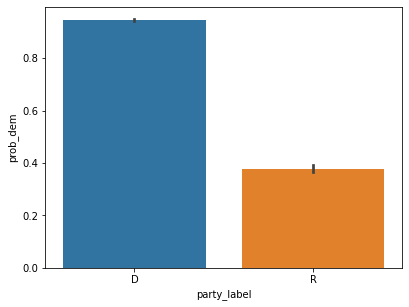

/Users/nicolasbaldwin/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/nicolasbaldwin/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



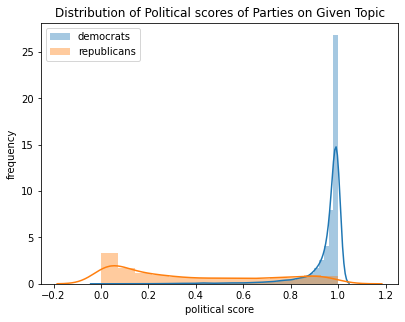

plot of subsample of quotes around mean prob dem of party


plot of position of speakers on subject with at least 4 quotes


,party_label,year,0
0,D,2015,"[energy, world, u, global, country, one, people, issue, impact, state]"
1,D,2016,"[energy, people, think, u, issue, country, world, state, clean, trump]"
2,D,2017,"[state, u, trump, energy, world, president, global, people, country, city]"
3,D,2018,"[energy, state, new, u, need, issue, people, clean, community, real]"
4,D,2019,"[issue, people, u, need, state, energy, new, threat, one, address]"
5,D,2020,"[issue, world, health, u, need, like, crisis, care, energy, people]"
6,R,2015,"[think, people, president, science, human, global, u, problem, way, obama]"
7,R,2016,"[issue, think, want, global, science, trump, state, risk, real, u]"
8,R,2017,"[president, state, u, think, trump, issue, global, people, science, world]"
9,R,2018,"[think, global, impact, need, issue, human, state, u, year, people]"


In [86]:
fig,fig2,fig3 = plot_topic_opinions(res,keywords,sample_size = 100)

In [88]:
send_figure_to_internet(fig,'Climate Change 1')
send_figure_to_internet(fig2,'Climate Change 2')
send_figure_to_internet(fig3,'Climate Change 3')

https://plotly.com/~ogim/44/
link:
<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~ogim/44.embed" height="525" width="100%"></iframe>
https://plotly.com/~ogim/46/
link:
<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~ogim/46.embed" height="525" width="100%"></iframe>
https://plotly.com/~ogim/48/
link:
<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~ogim/48.embed" height="525" width="100%"></iframe>


### Income abortion law analysis:

In [90]:
keywords = ['abortion','law']
res1 = get_quotes_off_keyword(file,keywords,min_length_quote=5,keep_RD=False,keep_exclusives=True)

0  1  2  3  4  5  6  7  

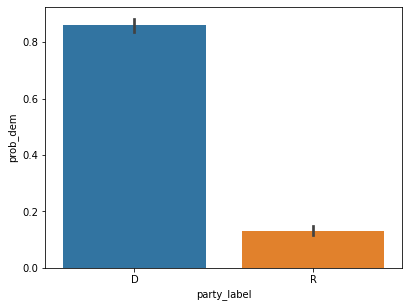

/Users/nicolasbaldwin/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/nicolasbaldwin/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



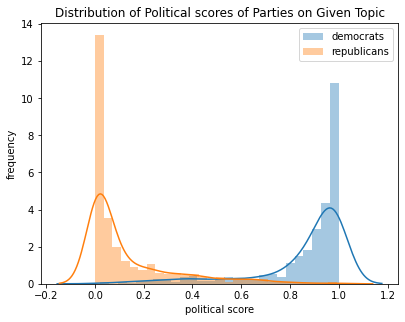

plot of subsample of quotes around mean prob dem of party


plot of position of speakers on subject with at least 4 quotes


,party_label,year,0
0,D,2015,"[woman, health, federal, state, parenthood, u, one, bill, medical, access]"
1,D,2016,"[woman, state, right, health, access, life, reproductive, also, pas, restriction]"
2,D,2017,"[woman, health, state, right, access, federal, reproductive, care, service, ban]"
3,D,2018,"[woman, care, right, state, service, court, health, require, tell, trump]"
4,D,2019,"[woman, state, health, right, access, reproductive, care, new, court, roe]"
5,D,2020,"[woman, right, state, health, access, care, doctor, protection, reproductive, california]"
6,R,2015,"[parenthood, state, federal, health, life, baby, part, woman, bill, child]"
7,R,2016,"[federal, life, court, state, woman, clinic, pro, taxpayer, legislation, illegal]"
8,R,2017,"[state, right, life, court, u, woman, federal, present, country, child]"
9,R,2018,"[right, state, life, court, government, minor, u, woman, supreme, pro]"


In [91]:
fig,fig2,fig3 = plot_topic_opinions(res1,keywords,sample_size = 100)

In [92]:
send_figure_to_internet(fig,'abortion law 1')
send_figure_to_internet(fig2,'abortion law 2')
send_figure_to_internet(fig3,'abortion law 3')

https://plotly.com/~ogim/53/
link:
<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~ogim/53.embed" height="525" width="100%"></iframe>
https://plotly.com/~ogim/55/
link:
<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~ogim/55.embed" height="525" width="100%"></iframe>
https://plotly.com/~ogim/57/
link:
<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~ogim/57.embed" height="525" width="100%"></iframe>
